In [31]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
using DiffEqFlux
using Optim
using ForwardDiff
using DelimitedFiles

In [32]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

function dPot3_dphi(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return (im * Pot3Const) .* (M - M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [33]:
#[Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
# p = [2, 10, 10, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]
p = [2, 10, 10, 0.7, 0.0, 1.0*2.482542369189332, 1.0/0.2949509890806259, 0.995pi, 0.0]

function limit_func(param,pmin,pmax)
    if pmin < param < pmax
        return param
    elseif param <= pmin
        return pmin
    else
        return pmax
    end
end

function alpha(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    αmin = limit_func(p[4],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

dalphadt(p, t) = ForwardDiff.derivative(t̃ -> alpha(p,t̃), t)
dalphadp(p, t) = ForwardDiff.gradient(p̃ -> alpha(p̃,t), p)
ddalphadpdt(p, t) = ForwardDiff.gradient(p̃ -> dalphadt(p̃,t), p)

function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    if Tₐ < t < Tₐ + Tᵣ
        arg = pi / 2 * (t - Tₐ) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
    elseif Tₐ + Tᵣ <= t <= Tₐ + Tₚ - Tᵣ
        E *= 1
        Edot *= 0
    elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
        arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
    else
        E *= 0
        Edot *= 0
    end
    return (E, Edot)
end

function pulse(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    Tᵣ = limit_func(p[1],0,Tₚ/2)
    # αmin = p[4]
    ϕ = p[5]
    f = p[6]
    A = p[7]
    # Φ_ext = p[8]
    λ = p[9]

    amp = pi * A / (Tₚ - Tᵣ)
    E = amp
    Edot = copy(amp)
    E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    arg = f*(t - Tₐ) + ϕ
    return E*cos(arg) + Edot*λ*sin(arg)
end

dpulsedt(p, t) = ForwardDiff.derivative(t̃ -> pulse(p, t̃), t)
dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

dpulsedp (generic function with 1 method)

In [34]:
Es = eigvals(Matrix(KinPot12 + Potential3))
ψs = eigvecs(Matrix(KinPot12 + Potential3));

N=30
# Ua = ψs[:,1:N]'*Potential3*ψs[:,1:N]
Um = ψs[:,1:N]'*(Pot3Const * exp(im * phi_ext) * Pot3Mat) * ψs[:,1:N]
Uv = ψs[:,1:N]'*chargecoupling*ψs[:,1:N]
ψ0 = zeros(N,2)
ψ0[1,1] = 1.0
ψ0[2,2] = 1.0

u0 = cat(real(Es[1:N].-Es[1]),Um,Uv,ψ0,dims=2)

Hphimærke = dPot3_dphi(phi_ext)
Hphi = KinPot12 + Potential3
IdNH = diagm(ones(ComplexF64, NHilbert))
E1mærke = ψs[:,1]'* Hphimærke * ψs[:,1]
E2mærke = ψs[:,2]'* Hphimærke * ψs[:,2]
tmp1 = - (Hphi - (real(Es[1]) .* IdNH)) \ (Hphimærke - (E1mærke .* IdNH))
tmp2 = - (Hphi - (real(Es[2]) .* IdNH)) \ (Hphimærke - (E2mærke .* IdNH))

fu0 = cat(u0,-ψs[:,1:N]'*tmp1*ψs[:,1],-ψs[:,1:N]'*tmp2*ψs[:,2],dims=2)

sizep = length(p)
diag_idxs = diagind(Um);

In [35]:
function f!(du, u, p, t)
    D = u[:,1]
    Um = u[:,2:N+1] #Ua = Um + Um'
    Uv = u[:,N+2:2*N+1]
    x = u[:,2*N+2:2*N+3]
    ψ = u[:,2*N+4:2*N+5]

    tmp = (Um + Um') .* dalphadt(p,t)
    
    F =  1 ./ (D .- D')
    F[diag_idxs] .= 0.0
    UddU = F .* tmp

    du[:,1] = real(diag(tmp))
    du[:,2:N+1] = UddU*Um - Um*UddU
    du[:,N+2:2*N+1] = UddU*Uv - Uv*UddU
    du[:,2*N+2:2*N+3] = (-im .* (diagm(D) + Uv .* pulse(p,t)) + UddU) * x
    du[:,2*N+4:2*N+5] = (-im .* (diagm(D) + Uv .* pulse(p,t)) + UddU) * ψ - alpha(p,t) * (Um - Um') * x
end

function b!(du, u, p, t)
    D = u[:,1]
    Um = u[:,2:N+1] #Ua = Um + Um'
    Uv = u[:,N+2:2*N+1]
    x = u[:,2*N+2:2*N+3]
    ψ = u[:,2*N+4:2*N+5]
    λ = u[:,2*N+6:2*N+7]
    ϕ = u[:,2*N+8:2*N+9]
    ps = u[:,2*N+10]

    Ua = Um + Um'
    dUa = Um - Um'
    tmp = Ua .* dalphadt(p,t)
    
    F =  1 ./ (D .- D')
    F[diag_idxs] .= 0.0
    UddU = F .* tmp

    du[:,1] = real(diag(tmp))
    du[:,2:N+1] = UddU*Um - Um*UddU
    du[:,N+2:2*N+1] = UddU*Uv - Uv*UddU

    miH = -im .* (diagm(D) + Uv .* pulse(p,t)) + UddU

    du[:,2*N+2:2*N+3] = miH * x
    du[:,2*N+4:2*N+5] = miH * ψ - alpha(p,t) * dUa * x
    du[:,2*N+6:2*N+7] = miH * λ
    du[:,2*N+8:2*N+9] = miH * ϕ + alpha(p,t) * dUa * λ
    
    du[1:sizep,2*N+10] = - real(im * tr(λ' * Uv * x)) .* dpulsedp(p, t) - real(im * tr(λ' * Ua * x)) .* dalphadp(p,t) + real(tr(λ' * (F .* Ua) * x)) .* ddalphadpdt(p,t)
    du[8,2*N+10] = real(tr(λ' * dUa * x) * alpha(p,t)) + real(im*tr(λ'*(F.*dUa)*x)) * dalphadt(p,t)
    du[sizep+1:2*sizep,2*N+10] = - real(im * (tr(ϕ' * Uv * x) + tr(ψ' * Uv * λ))) .* dpulsedp(p,t) - real(im * (tr(ϕ' * Ua * x) + tr(ψ' * Ua * λ))) .* dalphadp(p,t) + real(tr(ϕ' * (F .* Ua) * x) + tr(ψ' * (F .* Ua) * λ)) .* ddalphadpdt(p,t) - real(tr(x' * dUa * λ)) .* dalphadp(p,t) - real(im * tr(x' * (F .* dUa)' * λ)) .* ddalphadpdt(p,t)
end

b! (generic function with 1 method)

In [73]:
m = 0.1
l1s = []
l2s = []
params = []
calls = []

grad = zeros(sizep)
loss = [0.0]

function calc(p, last_p, grad, loss)
    if p != last_p
        copy!(last_p, p)
        forward_prob = ODEProblem(f!, fu0, (0.0, 30.0), p)
        sol_f = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-10)

        DT = sol_f.u[end][:,1]
        UmT = sol_f.u[end][:,2:N+1] #Ua = Um + Um'
        UvT = sol_f.u[end][:,N+2:2*N+1]
        xT = sol_f.u[end][:,2*N+2:2*N+3]
        ψT = sol_f.u[end][:,2*N+4:2*N+5]

        λ = cat(ψ0[:,2]*ψ0[:,2]'*xT[:,1],ψ0[:,1]*ψ0[:,1]'*xT[:,2],dims=2)
        ϕ = cat(-ψ0[:,2]*ψ0[:,2]'*ψT[:,1],-ψ0[:,1]*ψ0[:,1]'*ψT[:,2],dims=2)

        ps = zeros(N,1) #only 2*length(p) are possibly used
        bu0 = cat(DT,UmT,UvT,xT,ψT,λ,ϕ,ps,dims=2);

        backward_prob = ODEProblem(b!, bu0, (30.0, 0.0), p)
        sol_b = solve(backward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-10)

        UT = abs2.(ψ0'*xT)
        infidelity = 0.5 * (2 - UT[1,2] - UT[2,1])
        grad_phi = real(sol_b.u[end][8,2*N+10])

        loss[1] = infidelity + m * abs(grad_phi)
        grad[:] = real(sol_b.u[end][1:sizep,2*N+10]) + m * sign(grad_phi) .* real(sol_b.u[end][sizep+1:2*sizep,2*N+10])

        push!(l1s, copy(infidelity))
        push!(l2s, copy(grad_phi))
        push!(params, copy(p))
    end
end


function opt_func(p, last_p, grad, loss)
    calc(p, last_p, grad, loss)
    push!(calls, 0)
    return loss[1]
end

function get_grad!(grad, p, last_p, loss)
    calc(p, last_p, grad, loss)
    push!(calls,1)
end


get_grad! (generic function with 2 methods)

In [161]:
sum(calls[1:2:end]), sum(calls[2:2:end-1])

(1649, 0)

In [74]:
initial_p = copy(p)
last_p = similar(initial_p);

In [75]:
res = optimize(p -> opt_func(p, last_p, grad, loss),
               (grad, p) -> get_grad!(grad, p, last_p, loss),
               initial_p,BFGS())

┌ Warning: dt(-3.334849799898806e-15) <= dtmin(3.552713678800501e-15) at t=24.08407166995932. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\jv97\.julia\packages\SciMLBase\RAGXU\src\integrator_interface.jl:516
┌ Warning: dt(-3.2653510287454223e-15) <= dtmin(3.552713678800501e-15) at t=5.91597164740712. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\jv97\.julia\packages\SciMLBase\RAGXU\src\integrator_interface.jl:516


┌ Warning: dt(3.552713678800501e-15) <= dtmin(3.552713678800501e-15) at t=23.38898029753448. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\jv97\.julia\packages\SciMLBase\RAGXU\src\integrator_interface.jl:516
┌ Warning: dt(-3.5125338109377343e-15) <= dtmin(3.552713678800501e-15) at t=4.532465835144701. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\jv97\.julia\packages\SciMLBase\RAGXU\src\integrator_interface.jl:516


┌ Warning: dt(-3.552713678800501e-15) <= dtmin(3.552713678800501e-15) at t=8.109074125674097. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase C:\Users\jv97\.julia\packages\SciMLBase\RAGXU\src\integrator_interface.jl:516


 * Status: success

 * Candidate solution
    Final objective value:     5.498944e-03

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.10e+00 ≰ 1.0e-08

 * Work counters
    Seconds run:   69291  (vs limit Inf)
    Iterations:    43
    f(x) calls:    1649
    ∇f(x) calls:   1649


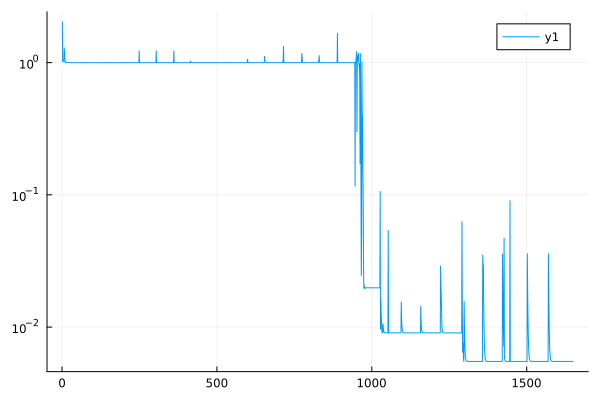

In [148]:
# plot([l1s,l2s])
plot(l1s + m*abs.(l2s),yaxis=:log)

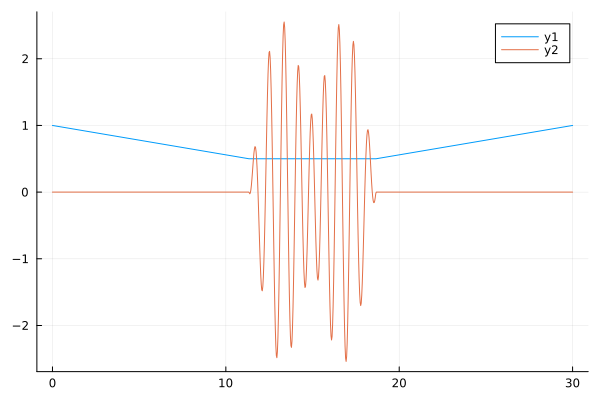

In [88]:
times = LinRange(0,30,1000)
plot(times, [[alpha(params[end],t) for t in times],
             [pulse(params[end],t) for t in times]])

In [92]:
# params[end] #[Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
l1s[end], l2s[end]

(0.00519030124147557, -0.0030864312007079825)

In [100]:
p_new = copy(Optim.minimizer(res));

In [101]:

forward_prob = ODEProblem(f!, fu0, (0.0, 30.0), p_new)
sol_f = solve(forward_prob, p=p_new, saveat=times, reltol=1e-8, abstol=1e-10)

retcode: Success
Interpolation: 1st order linear
t: 1000-element Vector{Float64}:
  0.0
  0.03003003003003003
  0.06006006006006006
  0.09009009009009009
  0.12012012012012012
  0.15015015015015015
  0.18018018018018017
  0.21021021021021022
  0.24024024024024024
  0.2702702702702703
  ⋮
 29.75975975975976
 29.78978978978979
 29.81981981981982
 29.84984984984985
 29.87987987987988
 29.90990990990991
 29.93993993993994
 29.96996996996997
 30.0
u: 1000-element Vector{Matrix{ComplexF64}}:
 [0.0 + 0.0im -12.694746782963147 - 24.455949616205622im … 0.13560581855983922 - 0.003927337058381834im 1.5689136759460285 - 0.0003555829988387263im; 1.5438914136931459 + 0.0im 0.23667702089969844 + 1.2094738031882772im … -1.5663165375257906 + 0.0001457230034430623im 0.15108147293050328 - 0.028458648593590374im; … ; 62.82746547287959 + 0.0im 0.8744911662307878 + 0.12239605119046967im … -0.00379360492421821 - 0.0001114663597984746im -0.006882839454721343 - 0.0004503534515507462im; 63.66542063788365 + 0.0i

In [105]:
occs = zeros(1000,2)

for (i,u) in enumerate(sol_f.u)
    occs[i,:] = abs2.(u[1:2,2*N+2])
end

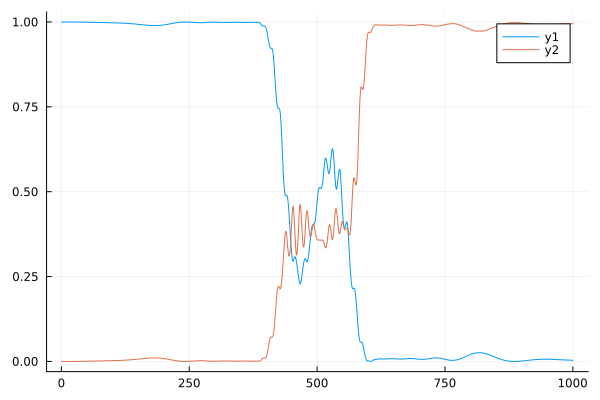

In [109]:
plot(occs)#,yaxis=:log,ylim=(1e-10,1))


In [78]:
# writedlm("tmp_l1s.txt",l1s)
# writedlm("tmp_l2s.txt",l2s)
# writedlm("tmp_params.txt",params)
# writedlm("tmp_calls.txt",calls)

In [113]:
function fidel(phi_ext,ps)
    Potential3 = get_Pot3(phi_ext)
    Es, ψs = eigs(KinPot12 + Potential3, nev=2, which=:SR, tol=0.0, maxiter=10000);

    function H!(du, u, p, t)
        du[:] = - im * (KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling) * u
    end

    forward_prob = ODEProblem(H!, ψs, (0.0, 30.0), ps)
    sol = solve(forward_prob, p=ps, save_everystep=false, reltol=1e-8, abstol=1e-10)

    UT = abs2.(ψs'*sol.u[end])
    return 0.5 * (2 - UT[1,2] - UT[2,1])
end    

fidel (generic function with 1 method)

In [119]:
tmp1_losses = []
tmp2_losses = []
p1 = [2, 10, 10, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]
p2 = copy(p_new)
for phi in [0.99pi, 0.991pi, 0.992pi, 0.993pi, 0.994pi,0.995pi,0.996pi, 0.997pi, 0.998pi, 0.999pi, pi]
    push!(tmp1_losses,fidel(phi,p1))
    push!(tmp2_losses,fidel(phi,p2))
end

In [122]:
tmp2_losses

11-element Vector{Any}:
 0.14819120357333726
 0.15352591725880033
 0.15954428177360458
 0.1658422965999684
 0.17481226337085642
 0.18355267693060967
 0.1892301894509829
 0.20311609018191745
 0.2449760227909702
 0.30316004392454987
 0.19113222891230947

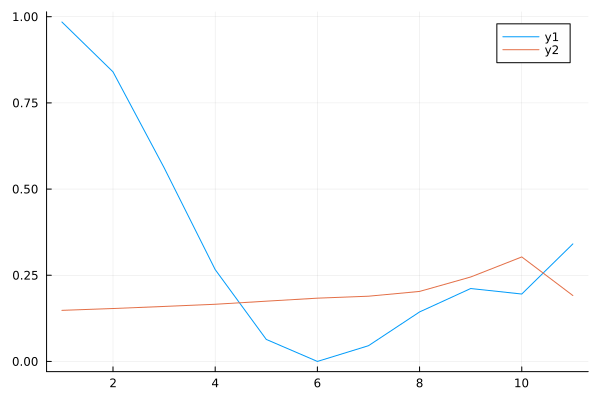

In [120]:
plot([tmp1_losses,tmp2_losses])

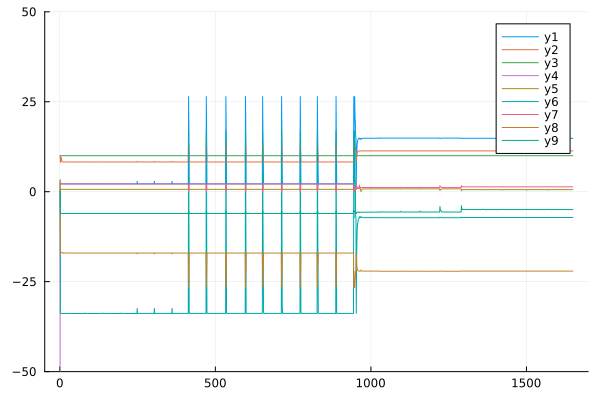

In [146]:
plot(transpose(cat(params...,dims=2)),ylim=(-50,50))


In [149]:
p_new

9-element Vector{Float64}:
   14.84292607534555
   11.341751839758764
   10.0
 -649.7661732132904
    0.5828557110984577
   -7.161153490188593
    1.3640811715268795
  -22.06506034791423
   -4.957612200539009